## Testing DPT


In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from Lseg.dpt import DPT
from Lseg.vit_wrapper import VisualTransformerWrapper
import torchvision.transforms as transforms
from PIL import Image

1. Testing whether the pretrained ViT encoder works with arbitrary image size


In [ ]:
image = Image.open("data/goldfish_imagenet_example.jpg")
transform = transforms.Compose(
    [
        transforms.Resize(
            (320, 320)
        ),  # Resize the image (different from 224, which is the pretrained model image size)
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    ]
)
image_tensor = transform(image)

# Put image tensor in batch form
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.shape)

model = VisualTransformerWrapper(layers_to_hook=[])
prediction = model(image_tensor)
print(torch.argmax(prediction), "Should be 1 (corresponds to GoldFish)")

2. Test my DPT implementation is correct by just training on five images (overfit), and verify image segmentation result.


In [2]:
# Use the recommended head for image segmentation
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode, align_corners=False):
        super().__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        x = self.interp(
            x,
            scale_factor=self.scale_factor,
            mode=self.mode,
            align_corners=self.align_corners,
        )
        return x


output_feature_dim = 256
num_classes_ADE20K = 3
head = nn.Sequential(
    nn.Conv2d(output_feature_dim, output_feature_dim, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(output_feature_dim),
    nn.ReLU(True),
    nn.Dropout(0.1, False),
    nn.Conv2d(output_feature_dim, num_classes_ADE20K, kernel_size=1),
    Interpolate(scale_factor=2, mode="bilinear", align_corners=True),
)

# Create DPT model
segmentation_model = DPT(head=head, output_feature_dim=output_feature_dim)

Training code


In [3]:
import PIL.Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob
import os
import PIL
from torchvision.transforms import v2
import pathlib


# Defining LightningModule
class DPTModule(pl.LightningModule):
    def __init__(self, dpt_model: DPT):
        super().__init__()
        self.model = dpt_model
        self.max_epochs = 100
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=4e-3, momentum=0.9, weight_decay=1e-4)
        # polynomial learning rate scheduler with decay factor 0:9.
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: pow(1.0 - epoch / self.max_epochs, 0.9)
        )
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = self.loss_fn(y_pred, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, on_epoch=True)
        return loss


dpt_module = DPTModule(segmentation_model)


# Defining Data
# Code adapted from https://discuss.pytorch.org/t/loading-ade20k-dataset/48684
class SegmentationDataset(Dataset):
    def __init__(self, folder_path):
        super().__init__()
        self.img_files = glob.glob(os.path.join(folder_path, "semantic_img", "*.jpg"))
        self.mask_files = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path, "semantic_img_mask", pathlib.Path(img_path).stem + ".png"))

        self.transforms = v2.Compose(
            [
                v2.Resize(size=(480, 480)),
                v2.ToTensor(),
                v2.ToDtype(torch.float32, scale=True),
            ]
        )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        img = PIL.Image.open(img_path)
        label = PIL.Image.open(mask_path)
        img = self.transforms(img)
        label = self.transforms(label)
        return img, label

    def __len__(self):
        return len(self.img_files)


train_dataset = SegmentationDataset(folder_path="data")
train_loader = DataLoader(train_dataset, num_workers=4, batch_size=2, shuffle=False, pin_memory=True)
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",  # Metric to monitor
    mode="min",  # Save the model with the minimum training loss
    save_top_k=1,  # Only keep the best model
    filename="epoch={epoch}-train_loss={train_loss:.4f}",  # Filename format
    verbose=False,
)

# Train
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=1, log_every_n_steps=1, callbacks=[checkpoint_callback])


trainer.fit(model=dpt_module, train_dataloaders=train_loader)


/home/richard/miniconda3/envs/dl/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | DPT     | 416 M  

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Check Progress optionally on tensorboard: `tensorboard --logdir .`


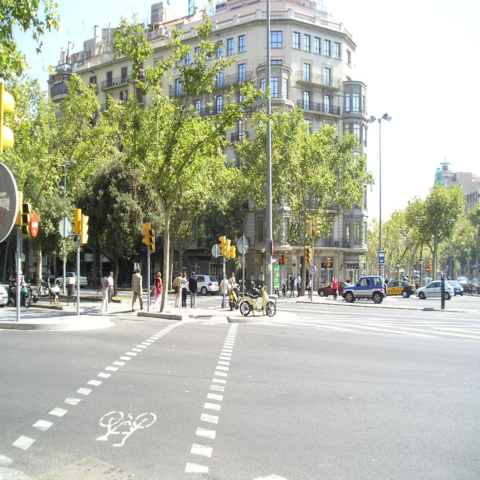

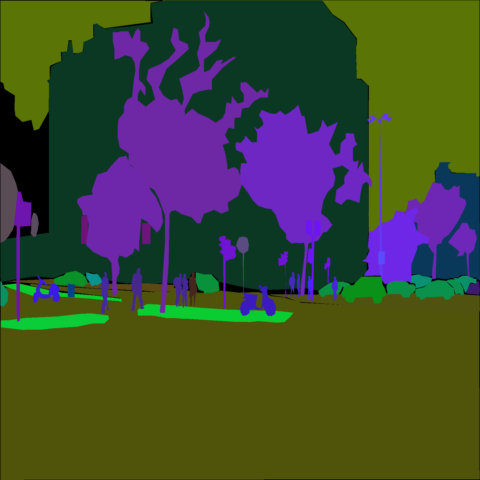

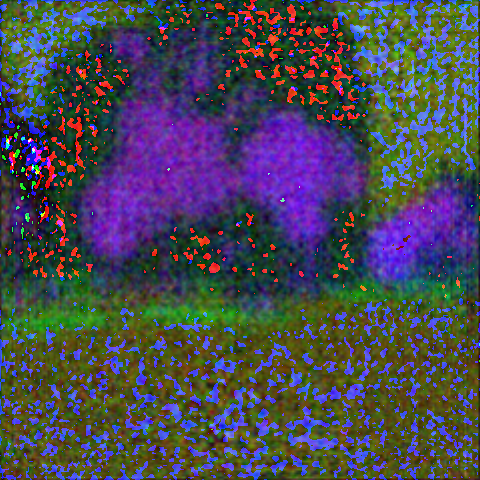

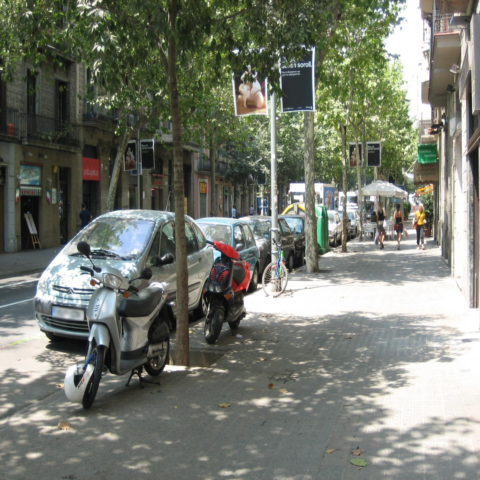

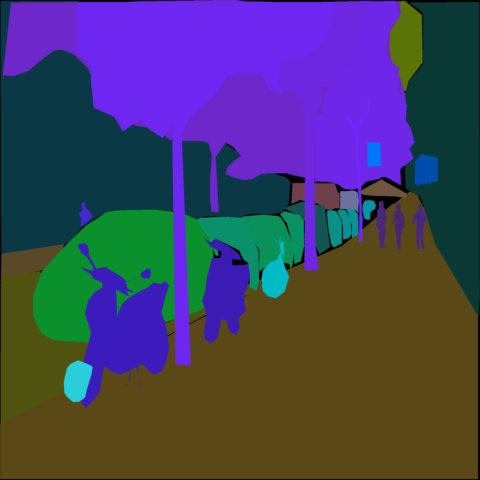

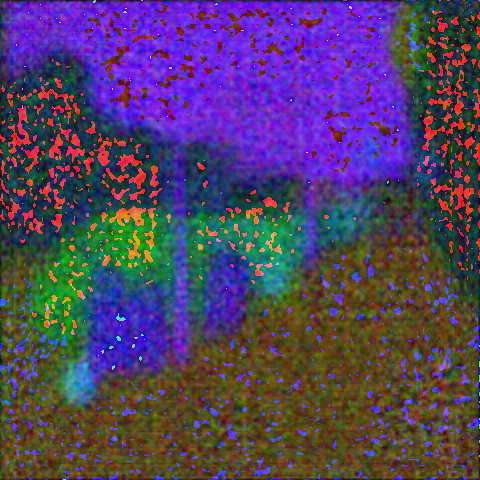

In [4]:
# Visualize image and prediction:
with torch.no_grad():
    dpt_module.eval()
    for img_tensor, label_tensor in train_dataset:
        pred_tensor = dpt_module(img_tensor.unsqueeze(0))
        pred_img_mask = v2.ToPILImage()(pred_tensor.squeeze(0))
        true_img = v2.ToPILImage()(img_tensor.squeeze(0))
        true_img_mask = v2.ToPILImage()(label_tensor.squeeze(0))
        true_img.show()
        true_img_mask.show()
        pred_img_mask.show()